<a href="https://colab.research.google.com/github/tijazz/Image_Processing/blob/main/CNN_1%2C_3%2C_4_layers_for_Alzheimer_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
!unzip -uq "/content/Alzheimer_Dataset.zip" -d "/content/"
print("The file has been unzipped successfully")

The file has been unzipped successfully


In [ ]:
#train_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="training",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )

train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [ ]:
#valid_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="validation",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [ ]:
#test_dataset = tf.keras.preprocessing.image_dataset_from_directory("../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
##                                                            shuffle=False,
#                                                            image_size=(224,224),
#                                                            batch_size=32,
#)

test_dataset = test_datagen.flow_from_directory(directory = '/content/Alzheimer_Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


In [ ]:
input_shape = (224,224,3)

### MODEL BUILDING
CNN with 1 Convolutional Layer: 1 — 1-Conv CNN

In [ ]:
def build_model():
    
    '''Sequential Model creation'''
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding='same',strides=(3, 3),input_shape = (224,224,3),activation='relu'))
    
   
    model.add(MaxPooling2D(pool_size=(2,2),strides=3,padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               2000100   
                                                                 
 dense_3 (Dense)             (None, 4)                 404       
                                                        

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/10
129/129 [==============================] - 68s 515ms/step - loss: 4.4751 - accuracy: 0.7473 - precision: 0.4881 - recall: 0.2201 - auc: 0.7675 - f1_score: 0.2512 - val_loss: 1.0590 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.7807 - val_f1_score: 0.5004 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 65s 503ms/step - loss: 1.1572 - accuracy: 0.7447 - precision: 0.4812 - recall: 0.2718 - auc: 0.7714 - f1_score: 0.2996 - val_loss: 1.0372 - val_accuracy: 0.7493 - val_precision: 0.4348 - val_recall: 0.0098 - val_auc: 0.7832 - val_f1_score: 0.0187 - lr: 0.0063
Epoch 3/10
129/129 [==============================] - 66s 515ms/step - loss: 1.0406 - accuracy: 0.7518 - precision: 0.5080 - recall: 0.2318 - auc: 0.7795 - f1_score: 0.2607 - val_loss: 1.0344 - val_accuracy: 0.7522 - val_precision: 0.5050 - val_recall: 0.4467 - val_auc: 0.7867 - val_f1_score: 0.4727 - lr: 0.0040
Epoch 4/10
129/129 [==============================] - 66s 

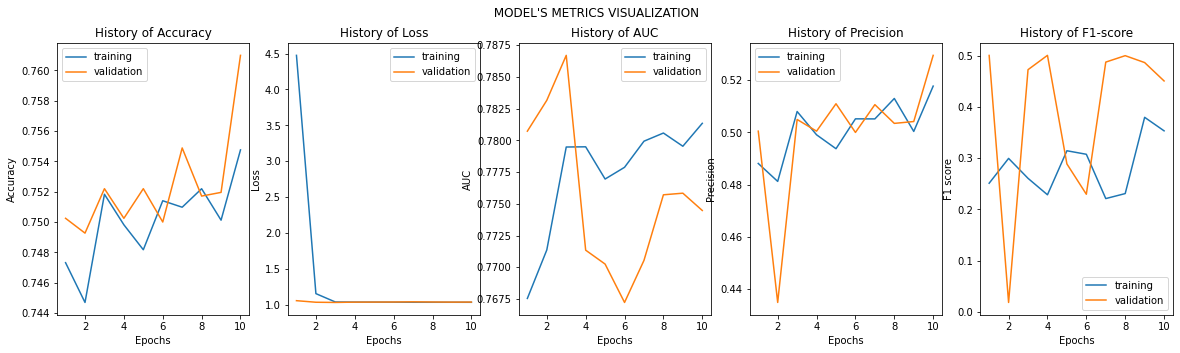

In [ ]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
scores = model.evaluate_generator(test_dataset)

<ipython-input-30-245a018ec215>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataset)


In [ ]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7640734910964966
Precision =  0.533088207244873
Recall =  0.4534792900085449
AUC =  0.7979929447174072
F1_score =  0.49022841453552246


###Model Building

CNN with 3 Convolutional Layer: 2 — 3-Conv CNN

In [ ]:
def build_model2():
    
    '''Sequential Model creation'''
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding='same',strides=(3, 3),input_shape = (224,224,3),activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2),strides=3,padding = 'same'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,(3,3),padding='same',strides=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding = 'same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3,3),padding='valid',strides=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding = 'same'))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

model2 = build_model2()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 9, 9, 64)         

In [ ]:
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history2=model2.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/10
129/129 [==============================] - 71s 537ms/step - loss: 2.3777 - accuracy: 0.7500 - precision: 0.5002 - recall: 0.2879 - auc: 0.7642 - f1_score: 0.2663 - val_loss: 1.0387 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7804 - val_f1_score: 0.0000e+00 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 66s 512ms/step - loss: 1.0462 - accuracy: 0.7496 - precision: 0.4980 - recall: 0.2162 - auc: 0.7772 - f1_score: 0.2199 - val_loss: 1.0409 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7826 - val_f1_score: 0.0000e+00 - lr: 0.0063
Epoch 3/10
129/129 [==============================] - 66s 509ms/step - loss: 1.0456 - accuracy: 0.7454 - precision: 0.4716 - recall: 0.1520 - auc: 0.7767 - f1_score: 0.1697 - val_loss: 1.0366 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7831 - val_f1_score: 0.0000e+00 - lr: 0.0040
Epoch 4/10
129/129 [==

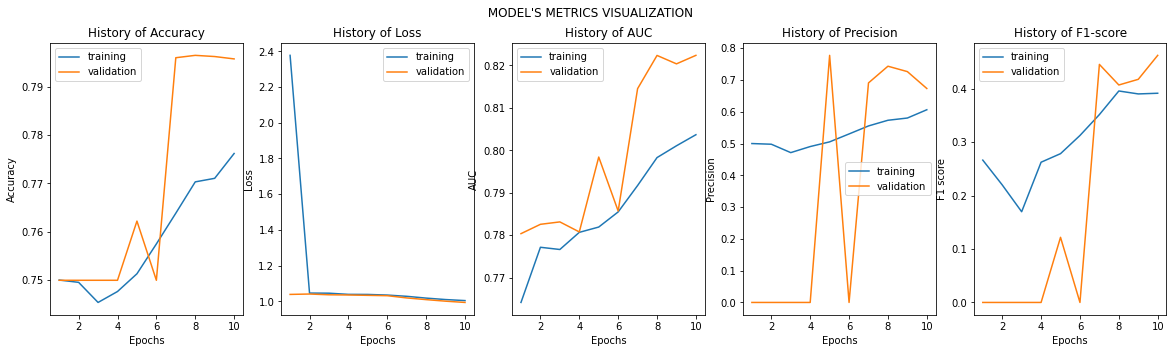

In [ ]:

Train_Val_Plot(history2.history['accuracy'],history2.history['val_accuracy'],
               history2.history['loss'],history2.history['val_loss'],
               history2.history['auc'],history2.history['val_auc'],
               history2.history['precision'],history2.history['val_precision'],
               history2.history['f1_score'],history2.history['val_f1_score']
              )

In [ ]:
scores2 = model2.evaluate_generator(test_dataset)

<ipython-input-40-cb4475939ce4>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores2 = model2.evaluate_generator(test_dataset)


In [ ]:
print("Accuracy = ", scores2[1])
print("Precision = ", scores2[2])
print("Recall = ", scores2[3])
print("AUC = ", scores2[4])
print("F1_score = ", scores2[5])

Accuracy =  0.7781469821929932
Precision =  0.5983606576919556
Recall =  0.34245502948760986
AUC =  0.8095543384552002
F1_score =  0.43262869119644165


###Model Building

CNN with 4 Convolutional Layer: 3 — 4-Conv CNN

In [ ]:
def build_model3():
    
    '''Sequential Model creation'''
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding='same',strides=(3, 3),input_shape = (224,224,3),activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2),strides=3,padding = 'same'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,(3,3),padding='same',strides=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding = 'same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3,3),padding='valid',strides=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding = 'same'))
    model.add(Dropout(0.4))

    
    model.add(Conv2D(256,(3,3),padding='same',strides=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding = 'same'))
    model.add(Dropout(0.5))

    model.add(Conv2D(512,(3,3),padding='same',strides=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding = 'same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

model3 = build_model3()
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 9, 9, 64)         

In [ ]:
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history3=model3.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/10
129/129 [==============================] - 78s 589ms/step - loss: 19.4505 - accuracy: 0.7511 - precision: 0.5045 - recall: 0.2520 - auc: 0.7716 - f1_score: 0.2620 - val_loss: 1.0431 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.7804 - val_f1_score: 0.5005 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 75s 577ms/step - loss: 1.0491 - accuracy: 0.7498 - precision: 0.4990 - recall: 0.2401 - auc: 0.7772 - f1_score: 0.2684 - val_loss: 1.0397 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.7804 - val_f1_score: 0.5004 - lr: 0.0063
Epoch 3/10
129/129 [==============================] - 77s 592ms/step - loss: 1.0415 - accuracy: 0.7496 - precision: 0.4980 - recall: 0.2155 - auc: 0.7792 - f1_score: 0.2331 - val_loss: 1.0346 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.7804 - val_f1_score: 0.5006 - lr: 0.0040
Epoch 4/10
129/129 [==============================] - 74s

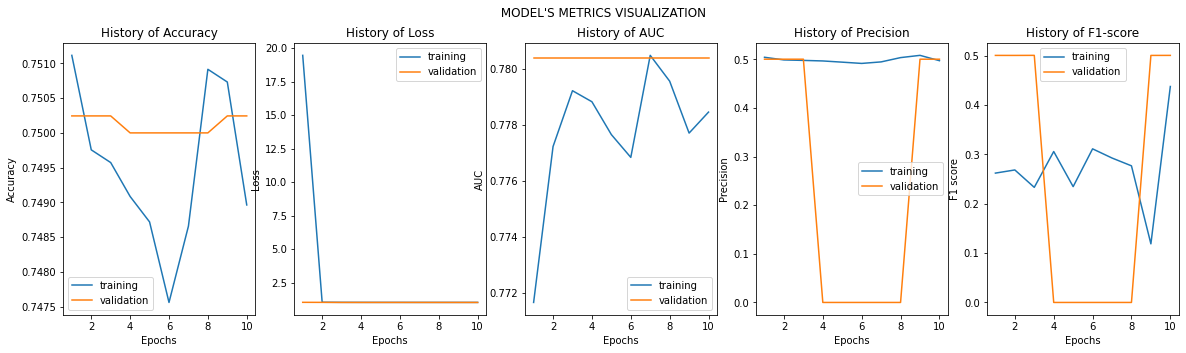

In [ ]:

Train_Val_Plot(history3.history['accuracy'],history3.history['val_accuracy'],
               history3.history['loss'],history3.history['val_loss'],
               history3.history['auc'],history3.history['val_auc'],
               history3.history['precision'],history3.history['val_precision'],
               history3.history['f1_score'],history3.history['val_f1_score']
              )

In [ ]:
scores3 = model3.evaluate_generator(test_dataset)

<ipython-input-46-7e00fa900a67>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores3 = model3.evaluate_generator(test_dataset)


In [ ]:
print("Accuracy = ", scores3[1])
print("Precision = ", scores3[2])
print("Recall = ", scores3[3])
print("AUC = ", scores3[4])
print("F1_score = ", scores3[5])

Accuracy =  0.7501954436302185
Precision =  0.5003909468650818
Recall =  0.5003909468650818
AUC =  0.7805577516555786
F1_score =  0.5004535913467407


### Model Building 


VGG 19 Pretrained Model

In [ ]:
import tensorflow 

import scipy
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras


In [ ]:
vgg = VGG19(input_shape= (224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=METRICS)
#metrics=[keras.metrics.AUC(name='auc')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [ ]:
history4 = modelvgg.fit(train_dataset, epochs=6, validation_data=valid_dataset, callbacks=callback)

Epoch 1/6
129/129 [==============================] - 3370s 26s/step - loss: 1.2187 - accuracy: 0.7608 - precision: 0.5262 - recall: 0.4356 - auc: 0.7851 - f1_score: 0.4733 - val_loss: 1.2129 - val_accuracy: 0.7603 - val_precision: 0.5281 - val_recall: 0.3861 - val_auc: 0.7549 - val_f1_score: 0.4442
Epoch 2/6
129/129 [==============================] - 3370s 26s/step - loss: 1.0788 - accuracy: 0.7770 - precision: 0.5634 - recall: 0.4790 - auc: 0.8159 - f1_score: 0.5124 - val_loss: 1.5005 - val_accuracy: 0.7480 - val_precision: 0.4960 - val_recall: 0.4858 - val_auc: 0.7822 - val_f1_score: 0.4906
Epoch 3/6
129/129 [==============================] - 3377s 26s/step - loss: 1.0185 - accuracy: 0.7941 - precision: 0.6028 - recall: 0.5171 - auc: 0.8349 - f1_score: 0.5558 - val_loss: 1.3558 - val_accuracy: 0.7224 - val_precision: 0.4127 - val_recall: 0.2610 - val_auc: 0.6855 - val_f1_score: 0.3191
Epoch 4/6
129/129 [==============================] - 3371s 26s/step - loss: 0.9962 - accuracy: 0.795

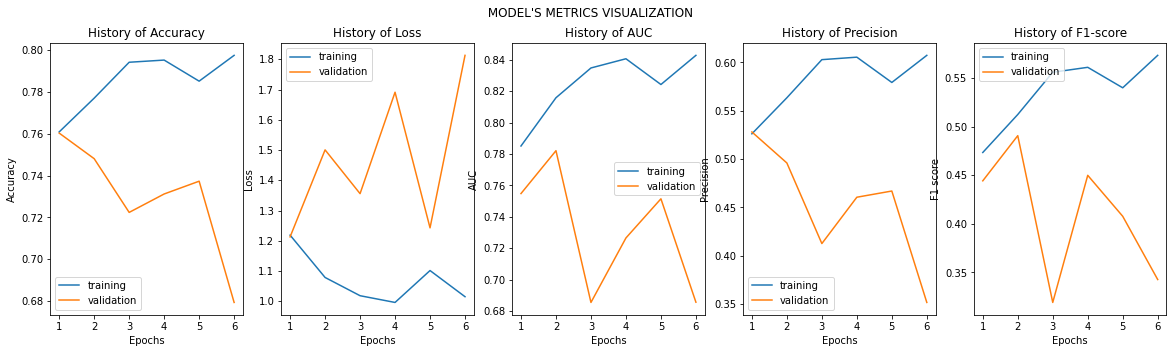

In [ ]:

Train_Val_Plot(history4.history['accuracy'],history4.history['val_accuracy'],
               history4.history['loss'],history4.history['val_loss'],
               history4.history['auc'],history4.history['val_auc'],
               history4.history['precision'],history4.history['val_precision'],
               history4.history['f1_score'],history4.history['val_f1_score']
              )

In [ ]:
scores4 = modelvgg.evaluate_generator(test_dataset)

print("Accuracy = ", scores4[1])
print("Precision = ", scores4[2])
print("Recall = ", scores4[3])
print("AUC = ", scores4[4])
print("F1_score = ", scores4[5])

<ipython-input-24-655d1c56d0ab>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores4 = modelvgg.evaluate_generator(test_dataset)


Accuracy =  0.753713846206665
Precision =  0.5076798796653748
Recall =  0.49100860953330994
AUC =  0.8242452144622803
F1_score =  0.49941301345825195


**VGG16** **Pretrained Model**

In [ ]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense
import keras
# load model
model = keras.models.Sequential()

# load model
VGG = VGG16(include_top=False, input_shape=(224,224,3),pooling='avg')    
print(VGG.summary())
# Freezing Layers

for layer in VGG.layers:
    layer.trainable=False
    
model.add(VGG)
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(n_classes,activation='softmax'))
model.summary()

### **test** you


In [ ]:
loss, accuracy = modelvgg.evaluate(valid_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

NameError: ignored